# Stabilité temporelle des modèles de segmentation

## Librairies

In [71]:
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from time import time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from IPython.core.display import HTML
import warnings

## Fonctions usuelles

In [72]:
pd. set_option('display.max_columns', None)
pd. set_option('display.max_rows', None)
pd. set_option('display.max_colwidth', None)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [198]:
def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    """The haversine formula makes it possible to determine the distance of the great circle 
        between two points of a sphere, from their longitudes and latitudes.

    Parameters
    ----------
    lat1, lat2 : float
        Latitudes of the 2 coordinate points to compare. 
    lng1, lng2 : float
        Longitudes of the 2 coordinate points to compare.
    degrees : boolean
        If True, converts radians to degrees.
    """
    # Radius of the earth in miles
    r = 3956 
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Haversine formula
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

def make_dataset(dpath="datas/", initial=False, period=2):
    """Cleaning and feature engineering on complete Olist data 
        for preparation of unsupervised classification (K-Means).

    Parameters
    ----------
    dpath : str
        Path to the directory containing the data.
    initial : boolean
        Defines whether the created dataset is the initial dataset.
    period : int
        Increment period in months after initial dataset.
    """
    start_time = time()
    print("Création du dataset en cours ...")
    
    # Root path
    root_path = dpath
    
    # Load datasets
    customers = pd.read_csv(root_path + "olist_customers_dataset.csv")
    geolocation = pd.read_csv(root_path + "olist_geolocation_dataset.csv")
    orders = pd.read_csv(root_path + "olist_orders_dataset.csv")
    order_items = pd.read_csv(root_path + "olist_order_items_dataset.csv")
    order_payments = pd.read_csv(root_path + "olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv(root_path + "olist_order_reviews_dataset.csv")
    products = pd.read_csv(root_path + "olist_products_dataset.csv")
    categories_en = pd.read_csv(root_path + "product_category_name_translation.csv")
    
    # Group location 
    geolocation = geolocation.groupby(["geolocation_state"]).agg({
            "geolocation_lat": "mean",
            "geolocation_lng": "mean"})
    
    # Merge datasets
    # Orders
    orders.drop(["order_approved_at",
                 "order_delivered_carrier_date", 
                 "order_estimated_delivery_date"],
                axis=1, inplace=True)

    order_items.drop(["seller_id",
                      "shipping_limit_date"],
                     axis=1, inplace=True)
    order_items = pd.merge(order_items, orders,
                           how="left",
                           on="order_id")
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        order_items[col] = order_items[col].astype('datetime64[ns]')
        
    # order Month
    order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
    
    # Select orders on period
    start=order_items["order_purchase_timestamp"].min()
    if period != 99:
        if(initial == True):
            period = 12
        else:
            period = 12+period
        stop=start + pd.DateOffset(months=period)
    else :
        print("period is 99")
        stop=order_items["order_purchase_timestamp"].max()
        
    order_items = order_items[(order_items["order_purchase_timestamp"]>=start)
                              & (order_items["order_purchase_timestamp"]<stop)]
    
    # List of orders on period
    period_orders = order_items.order_id.unique()
    
    # Calculate other features on period
    order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items, 
                           order_payments.groupby(by="order_id").agg(
                               {"payment_sequential": 'count',
                                "payment_installments": 'sum'}),
                           how="left",
                           on="order_id")
    order_items = order_items.rename(columns={
        "payment_sequential": "nb_payment_sequential",
        "payment_installments": "sum_payment_installments"})
    
    order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean"}),
                           how="left",
                           on="order_id")
    
    # Delivery time
    order_items["delivery_delta_days"] = (order_items.order_delivered_customer_date
                                          - order_items.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    # Products
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght", 
                         "product_description_lenght", "product_photos_qty"]
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english":
                                        "product_category_name"})
        
    products['product_category'] = np.where((products['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                            np.where((products['product_category_name'].str.contains("health|beauty|perfum")==True),
                                     'health_beauty',
                            np.where((products['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                            np.where((products['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                            np.where((products['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                            np.where((products['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                            np.where((products['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                     'home_furniture',
                            np.where((products['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                            np.where((products['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))
    products.drop("product_category_name", axis=1, inplace=True)

    order_items = pd.merge(order_items, products, 
                           how="left",
                           on="product_id")
    
    # Encode categories column
    order_items = pd.get_dummies(order_items, columns=["product_category"], prefix="", prefix_sep="")
    
    # Customers
    order_items = pd.merge(order_items, customers[["customer_id",
                                                   "customer_unique_id",
                                                   "customer_state"]],
                           on="customer_id",
                           how="left")
    
    # Group datas by unique customers
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_items=pd.NamedAgg(column="order_item_id", aggfunc="count"),
        total_spend=pd.NamedAgg(column="price", aggfunc="sum"),
        total_freight=pd.NamedAgg(column="freight_value", aggfunc="sum"),
        mean_payment_sequential=pd.NamedAgg(column="nb_payment_sequential", aggfunc="mean"),
        mean_payment_installments=pd.NamedAgg(column="sum_payment_installments", aggfunc="mean"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        books_cds_media=pd.NamedAgg(column="books_cds_media", aggfunc="sum"),
        fashion_clothing_accessories=pd.NamedAgg(column="fashion_clothing_accessories", aggfunc="sum"),
        flowers_gifts=pd.NamedAgg(column="flowers_gifts", aggfunc="sum"),
        groceries_food_drink=pd.NamedAgg(column="groceries_food_drink", aggfunc="sum"),
        health_beauty=pd.NamedAgg(column="health_beauty", aggfunc="sum"),
        home_furniture=pd.NamedAgg(column="home_furniture", aggfunc="sum"),
        other=pd.NamedAgg(column="other", aggfunc="sum"),
        sport=pd.NamedAgg(column="sport", aggfunc="sum"),
        technology=pd.NamedAgg(column="technology", aggfunc="sum"),
        toys_baby=pd.NamedAgg(column="toys_baby", aggfunc="sum"),
        customer_state=pd.NamedAgg(column="customer_state", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        favorite_sale_month=pd.NamedAgg(column="sale_month", 
                                        aggfunc=lambda x:x.value_counts().index[0]))
    
    # Final feature engineering
    # Categories items ratio
    cat_features = data.columns[7:17]
    for c in cat_features:
        data[c] = data[c] / data["total_items"]
    
    # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
#     data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # Freight ratio and total price
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data.drop("total_freight", axis=1, inplace=True)
    
    # Add Haversine distance of customer state
    # Haversine distance
    olist_lat = -25.43045
    olist_lon = -49.29207
        
    geolocation['haversine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y)
                                         for x, y in zip(geolocation.geolocation_lat,
                                                         geolocation.geolocation_lng)]
    data = pd.merge(data.reset_index(), geolocation[["haversine_distance"]],
                    how="left",
                    left_on="customer_state",
                    right_on="geolocation_state")
    data.drop(["customer_state"], axis=1, inplace=True)
    data.set_index("customer_unique_id", inplace=True)
    
    # complete missing values
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    
    print(54*"_")
    print("Features complétées avec la valeur la plus fréquente :")
    print(54*"_")
    for f in features_to_fill:
        data[f] = data[f].fillna(data[f].mode()[0])
        print(f,"\t", data[f].mode()[0])
    print(54*"_")
    
    end_time = time()
    print("Durée d'execution du Feature engineering : {:.2f}s".format(end_time - start_time))
    
    return data

def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    plt.show()
    return K
    
    
def process_recency(order_date_string):
    date_format = '%Y-%m-%d %H:%M:%S'
    last_order = datetime.strptime(str(data["last_order"].max()), date_format)
    last_customer_order = datetime.strptime(order_date_string,date_format)
    nb_days = (last_order - last_customer_order).days
    return nb_days

def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()
    if log_transf:
        data_temp = np.log(data_temp) + 1
        
    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    
    return cluster_group['cluster'].map(cluster_map)

def process_rfm(data):
    data["recency"] = data["last_order"].astype(str).apply(process_recency)
    r_labels = k_means_group(data[['recency']],5,1,asc=True)
    f_labels = k_means_group(data[['nb_orders']],5,1)
    m_labels = k_means_group(data[['total_spend']],5,1)
    data = data.assign(R = r_labels, F = f_labels, M = m_labels)
    return data

def process_data(data):
    data_r = data.copy()
    data_r = process_rfm(data_r)
    data_r = data_r[["R", "F", "M"]]
    return data_r

## Détermination de la période totale à couvrir

In [124]:
olist_path = "./data/"
orders = pd.read_csv(olist_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("Le jeu de donnée initial couvre une période de {} mois.".format(time_delta))

Le jeu de donnée initial couvre une période de 23 mois.


In [184]:
orders.max()

Timestamp('2018-08-29 15:00:37')

In [185]:
orders.min()

Timestamp('2016-09-15 12:16:38')

## Evolution du nombre de nouveaux clients

Regardons tout d'abord commement évolue le nombre de nouveaux clients dans notre jeu de données :

In [201]:
data = make_dataset("./data/", period=99, initial=True)

Création du dataset en cours ...
period is 99
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 39.73s


In [202]:
print("premières commandes : ")
display(data.sort_values(by=["first_order"], ascending=True)["first_order"].head())
print("dernières premières commandes : ")
display(data.sort_values(by=["first_order"], ascending=True)["first_order"].tail())

premières commandes : 


customer_unique_id
b7d76e111c89f7ebf14761390f0f7d17   2016-09-04 21:15:19
4854e9b3feff728c13ee5fc7d1547e92   2016-09-05 00:15:34
830d5b7aaa3b6f1e9ad63703bec97d23   2016-09-15 12:16:38
0eb1ee9dba87f5b36b4613a65074337c   2016-10-02 22:07:52
32ea3bdedab835c3aa6cb68ce66565ef   2016-10-03 09:44:50
Name: first_order, dtype: datetime64[ns]

dernières premières commandes : 


customer_unique_id
7a22d14aa3c3599238509ddca4b93b01   2018-08-29 12:25:59
5c58de6fb80e93396e2f35642666b693   2018-08-29 14:18:23
7febafa06d9d8f232a900a2937f04338   2018-08-29 14:18:28
b701bebbdf478f5500348f03aff62121   2018-08-29 14:52:00
24ac2b4327e25baf39f2119e4228976a   2018-08-29 15:00:37
Name: first_order, dtype: datetime64[ns]

In [203]:
print("dernières commandes :")
data.sort_values(by=["last_order"], ascending=True)["last_order"].tail()

dernières commandes :


customer_unique_id
7a22d14aa3c3599238509ddca4b93b01   2018-08-29 12:25:59
5c58de6fb80e93396e2f35642666b693   2018-08-29 14:18:23
7febafa06d9d8f232a900a2937f04338   2018-08-29 14:18:28
b701bebbdf478f5500348f03aff62121   2018-08-29 14:52:00
24ac2b4327e25baf39f2119e4228976a   2018-08-29 15:00:37
Name: last_order, dtype: datetime64[ns]

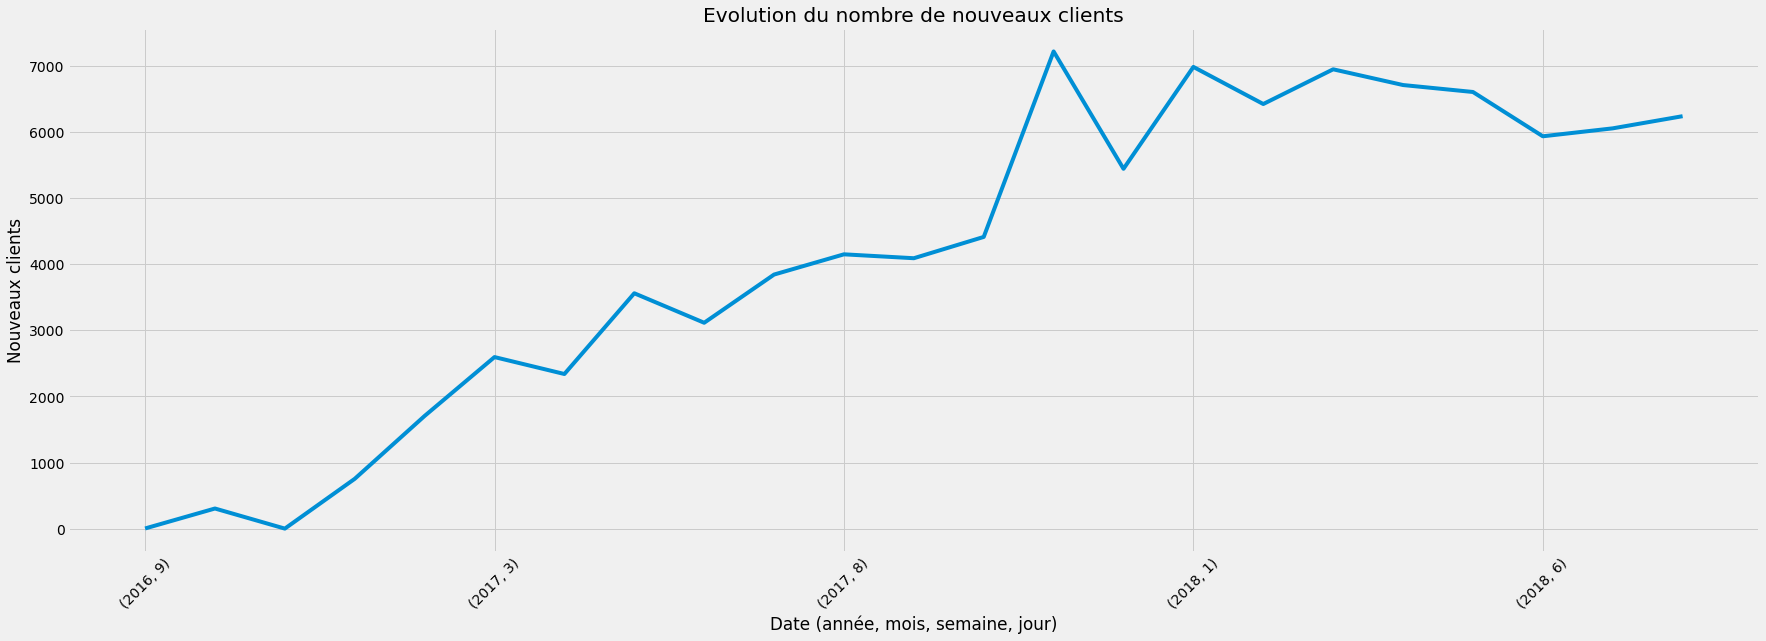

In [204]:
data.groupby(
    [
        data["first_order"].dt.year, 
        data["first_order"].dt.month,
    ]
).count()["first_order"].plot(figsize=(27,9))
plt.xticks(rotation=45)
plt.xlabel("Date (année, mois, semaine, jour)")
plt.ylabel("Nouveaux clients")
plt.title("Evolution du nombre de nouveaux clients")
plt.show()

On peut voir que le nombre de nouveaux clients augmente fortement au bout de 3 mois. Et globalement, on observe de grosses variations tous les trimestres. Basons-nous sur un delta de 3 mois pour voir comment évolue notre clustering

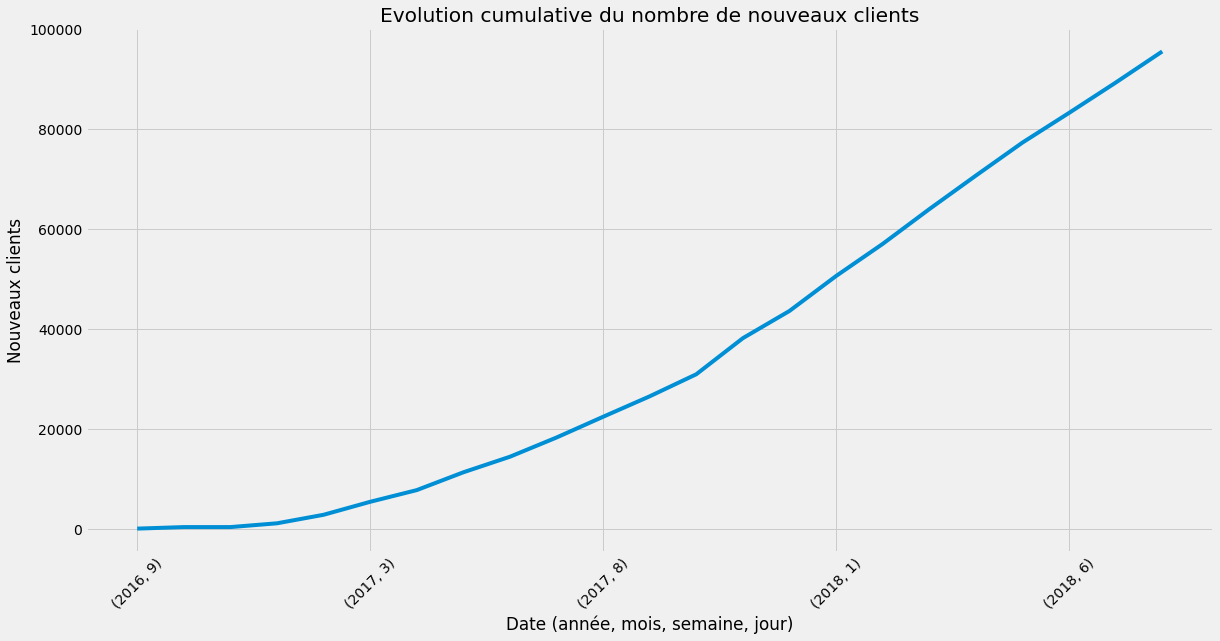

In [205]:
data.groupby(
    [
        data["first_order"].dt.year, 
        data["first_order"].dt.month,
#         data["first_order"].dt.week,
#         data["first_order"].dt.day
    ]
).count()["first_order"].cumsum().plot(figsize=(18,9))

plt.xticks(rotation=45)
plt.xlabel("Date (année, mois, semaine, jour)")
plt.ylabel("Nouveaux clients")
plt.title("Evolution cumulative du nombre de nouveaux clients")
plt.show()

Ici, nous avons le nombre cumulé de nouveaux clients en fonction du temps, sur toute la durée couverte par nos données. Le nombre de clients est faible le premier trimestre (de nos données, ce qui correspond aux dernier trimestre 2016), et commence à prendre son envol au cours du trimestre suivant.

## Stabilité temporelle

Nous allons d'abord entraîner notre meilleur modèle sur les données de la première année afin d'avoir une base de comparaison.

Rappellons que notre meilleur modèle était K-means avec K=3 et entraîné sur les données ne comprenant pas les catégories de produits, ni les variables issues de la segmentation métier (RFM).

In [121]:
products_categories = [
    'books_cds_media',
    'fashion_clothing_accessories',
    'flowers_gifts',
    'groceries_food_drink',
    'health_beauty',
    'home_furniture',
    'other',
    'sport',
    'technology',
    'toys_baby'
]

In [122]:
data_init = make_dataset(dpath="./data/", initial=True, period=0)
data_init.drop(products_categories, axis=1, inplace=True)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 10.76s


In [123]:
data_init.dropna(inplace=True)

In [125]:
X_init = data_init.select_dtypes(include=np.number)
kmeans_init = Pipeline(
    [
        ("preprocessor", MinMaxScaler()),
        ("kmeans", KMeans(3, random_state=1))
    ]
)
kmeans_init.fit(X_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

Maintenant, nous allons rééffectuer notre clustering plusieurs fois, avec un delta de 3 mois, et nous comparerons les labels des clients de notre première année, afin de voir s'il y a eu une évolution dans leur classification

In [132]:
ari_score = []
i=1
K=3
for p in np.arange(3,(time_delta+3),3):
    display(HTML("<h1>Itération n°{}</h1>".format(i)))
    
    # Creation du dataset pour la période p
    data_period = make_dataset(
        dpath="./data/", 
        initial=False, 
        period=p
    )
#     data_period = data_period[numerical_columns]
    data_period.drop(columns=products_categories, inplace=True)
    data_period = data_period.select_dtypes(include=np.number)
    
#     # Ne garde que les clients de la période initiale
#     data_period = data_period[data_period.index.isin(X_kmeans.index)]
    
    
    # K-Means (pour simuler des conditions réelles, nous entraînons d'abord notre
    # algorithme K-means avec les données de tous les clients sur la période couverte)
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=1))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    data_period["kmeans_labels"] = p_labels
    
    # Puis nous ne conservons que les clients de la période initiale
    data_period = data_period[data_period.index.isin(X_init.index)]
    
    # Calcul du score ARI
#     ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_p = adjusted_rand_score(init_labels, data_period["kmeans_labels"])
    ari_score.append([p,ari_p])
    
    display(HTML("<h2>Score ARI :</h2>"))
    to_display = pd.DataFrame({
        "période": [p],
        "ARI": [ari_p]
    })
    display(to_display)
    i+=1

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 17.43s


,période,ARI
0,3,0.330509


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 25.01s


,période,ARI
0,6,0.598247


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 33.16s


,période,ARI
0,9,0.906737


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.46s


,période,ARI
0,12,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.44s


,période,ARI
0,15,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.32s


,période,ARI
0,18,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.33s


,période,ARI
0,21,0.612838


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.19s


,période,ARI
0,24,0.612748


,periode,ARI
0,3,0.330509
1,6,0.598247
2,9,0.906737
3,12,0.612928
4,15,0.612928
5,18,0.612748
6,21,0.612838
7,24,0.612748


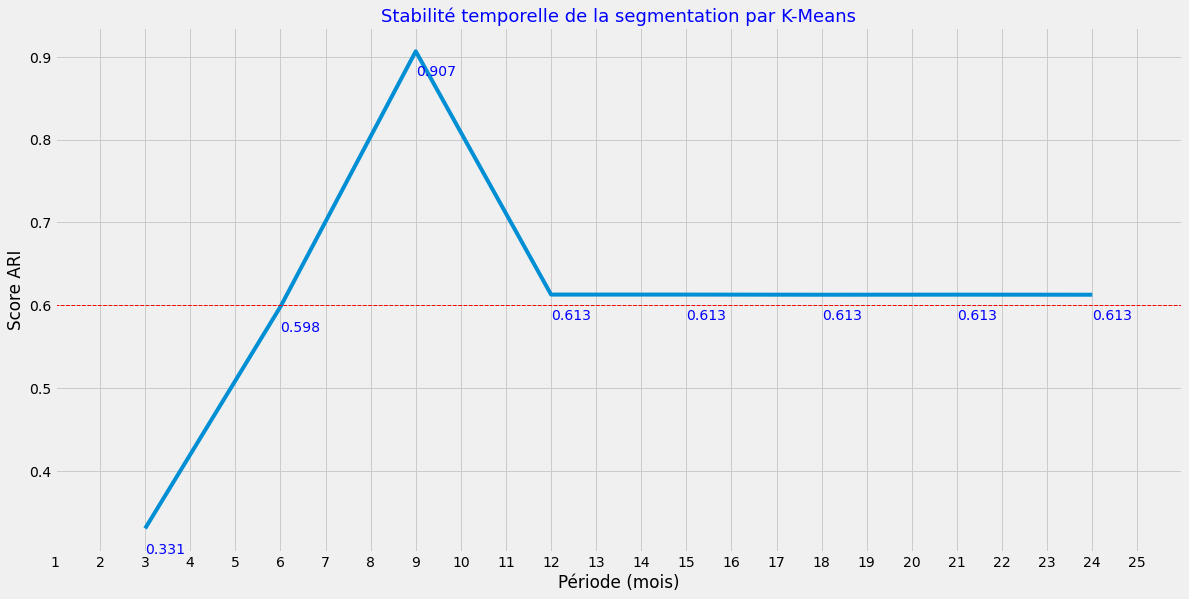

In [167]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])
display(ari_score)

# graphique de l'indice de Rand ajousté (ARI)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlim(1,time_delta+3)
plt.axhline(
    y=0.6, 
    linestyle="--", 
    color="red",
    linewidth=1
)
for x, y in zip(ari_score["periode"], ari_score["ARI"]):
    plt.text(
        x = x,
        y = y-0.03,
        s = "{:.3f}".format(y), 
        color = "blue"
    )
plt.xticks(np.arange(1,time_delta+3,1))
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

En réentraînant notre modèle tous les trois mois, l'ARI est généralement en dessous de 0.8, ce qui signifie que les classifications changent de manière significative.

Relançons tout avec un delta d'un mois, afin d'avoir une vision un peu plus fine :

In [134]:
ari_score_1month = []
i=1
K=3
for p in np.arange(1,(time_delta+3),1):
    display(HTML("<h1>Itération n°{}</h1>".format(i)))
    
    # Creation du dataset pour la période p
    data_period = make_dataset(
        dpath="./data/", 
        initial=False, 
        period=p
    )
    data_period.drop(columns=products_categories, inplace=True)
    data_period = data_period.select_dtypes(include=np.number)
    
    
    # K-Means (pour simuler des conditions réelles, nous entraînons d'abord notre
    # algorithme K-means avec les données de tous les clients sur la période couverte)
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=1))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    data_period["kmeans_labels"] = p_labels
    
    # Puis nous ne conservons que les clients de la période initiale
    data_period = data_period[data_period.index.isin(X_init.index)]
    
    # Calcul du score ARI
    ari_p = adjusted_rand_score(init_labels, data_period["kmeans_labels"])
    ari_score_1month.append([p,ari_p])
    
    display(HTML("<h2>Score ARI :</h2>"))
    to_display = pd.DataFrame({
        "période": [p],
        "ARI": [ari_p]
    })
    display(to_display)
    i+=1

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 12.57s


,période,ARI
0,1,0.976987


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 14.30s


,période,ARI
0,2,0.601614


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 17.42s


,période,ARI
0,3,0.330509


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 19.53s


,période,ARI
0,4,0.298755


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 22.36s


,période,ARI
0,5,0.576814


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 25.08s


,période,ARI
0,6,0.598247


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 27.80s


,période,ARI
0,7,0.621376


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 30.69s


,période,ARI
0,8,0.94054


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 33.15s


,période,ARI
0,9,0.906737


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 35.43s


,période,ARI
0,10,0.881846


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 38.38s


,période,ARI
0,11,0.86458


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.35s


,période,ARI
0,12,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.36s


,période,ARI
0,13,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.13s


,période,ARI
0,14,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.12s


,période,ARI
0,15,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.27s


,période,ARI
0,16,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.91s


,période,ARI
0,17,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.67s


,période,ARI
0,18,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.75s


,période,ARI
0,19,0.612838


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.76s


,période,ARI
0,20,0.612838


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.70s


,période,ARI
0,21,0.612838


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.77s


,période,ARI
0,22,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.60s


,période,ARI
0,23,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.13s


,période,ARI
0,24,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 39.98s


,période,ARI
0,25,0.612748


,periode,ARI


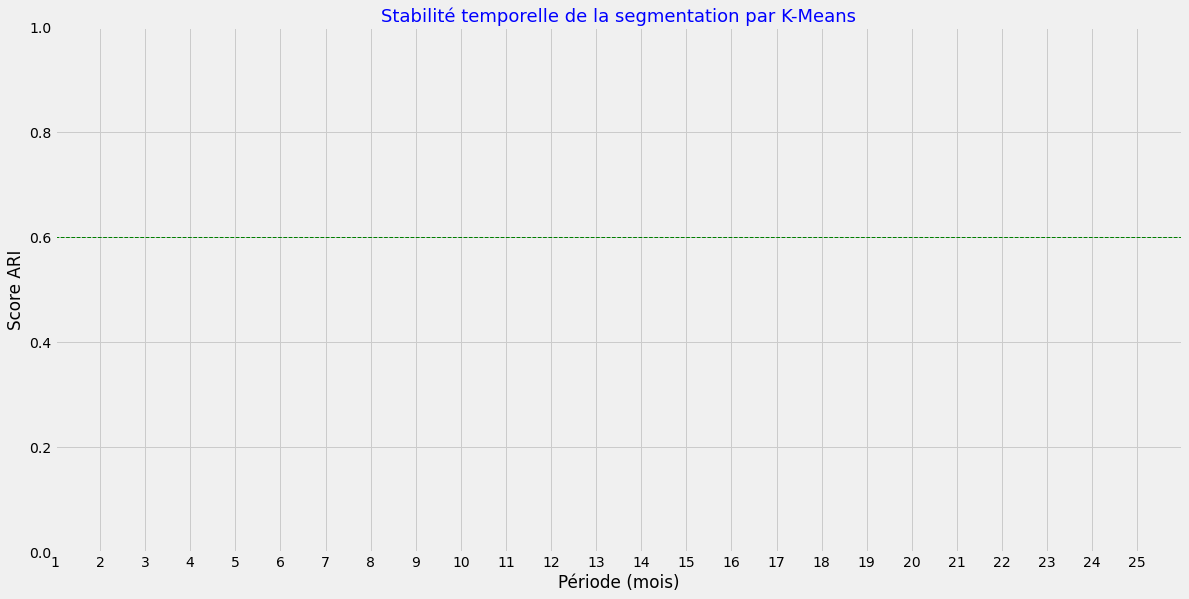

In [174]:
ari_score_1month = pd.DataFrame(ari_score_1month, columns=["periode", "ARI"])
display(ari_score_1month)

# graphique de l'indice de Rand ajousté (ARI)
fig = plt.figure(figsize=(18,9))
sns.lineplot(
    data=ari_score_1month, 
    x="periode", 
    y="ARI",
    marker="o"
)
plt.xlim(1,time_delta+3)
plt.axhline(
    y=0.6, 
    linestyle="--", 
    color="green",
    linewidth=1
)

for x, y in zip(ari_score_1month["periode"], ari_score_1month["ARI"]):
    plt.text(
        x = x,
        y = y-0.03,
        s = "{:.3f}".format(y), 
        color = "blue"
    )

plt.xticks(np.arange(1,time_delta+3,1))
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

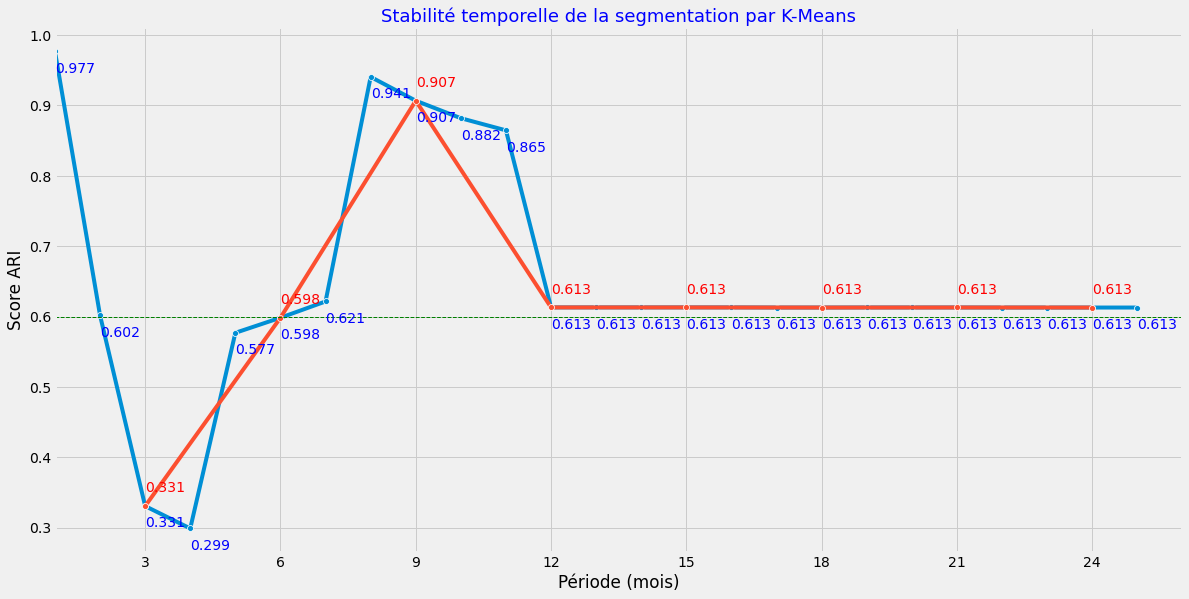

In [170]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(
    data=ari_score_1month, 
    x="periode", 
    y="ARI",
    marker='o'
)
sns.lineplot(
    data=ari_score, 
    x="periode", 
    y="ARI",
    marker='o'
)
plt.xlim(1,time_delta+3)
plt.axhline(
    y=0.6, 
    linestyle="--", 
    color="green",
    linewidth=1
)

# valeurs affichées près des marqueurs
for x, y in zip(ari_score["periode"], ari_score["ARI"]):
    plt.text(
        x = x,
        y = y+0.02,
        s = "{:.3f}".format(y), 
        color = "red"
    )
for x, y in zip(ari_score_1month["periode"], ari_score_1month["ARI"]):
    plt.text(
        x = x,
        y = y-0.03,
        s = "{:.3f}".format(y), 
        color = "blue"
    )


plt.xticks(np.arange(3,time_delta+3,3))
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Après 12 mois, on peut constater que les score AR

In [172]:
ari_score_2month = []
i=1
K=3
for p in np.arange(2,(time_delta+3),2):
    display(HTML("<h1>Itération n°{}</h1>".format(i)))
    
    # Creation du dataset pour la période p
    data_period = make_dataset(
        dpath="./data/", 
        initial=False, 
        period=p
    )
    data_period.drop(columns=products_categories, inplace=True)
    data_period = data_period.select_dtypes(include=np.number)
    
    
    # K-Means (pour simuler des conditions réelles, nous entraînons d'abord notre
    # algorithme K-means avec les données de tous les clients sur la période couverte)
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=1))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    data_period["kmeans_labels"] = p_labels
    
    # Puis nous ne conservons que les clients de la période initiale
    data_period = data_period[data_period.index.isin(X_init.index)]
    
    # Calcul du score ARI
    ari_p = adjusted_rand_score(init_labels, data_period["kmeans_labels"])
    ari_score_2month.append([p,ari_p])
    
    display(HTML("<h2>Score ARI :</h2>"))
    to_display = pd.DataFrame({
        "période": [p],
        "ARI": [ari_p]
    })
    display(to_display)
    i+=1

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 14.13s


,période,ARI
0,2,0.601614


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 19.34s


,période,ARI
0,4,0.298755


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 24.87s


,période,ARI
0,6,0.598247


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 30.39s


,période,ARI
0,8,0.94054


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 35.41s


,période,ARI
0,10,0.881846


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 39.96s


,période,ARI
0,12,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.08s


,période,ARI
0,14,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.03s


,période,ARI
0,16,0.612928


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.05s


,période,ARI
0,18,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.08s


,période,ARI
0,20,0.612838


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.07s


,période,ARI
0,22,0.612748


Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 40.10s


,période,ARI
0,24,0.612748


,periode,ARI
0,2,0.601614
1,4,0.298755
2,6,0.598247
3,8,0.940540
4,10,0.881846
5,12,0.612928
6,14,0.612928
7,16,0.612928
8,18,0.612748
9,20,0.612838


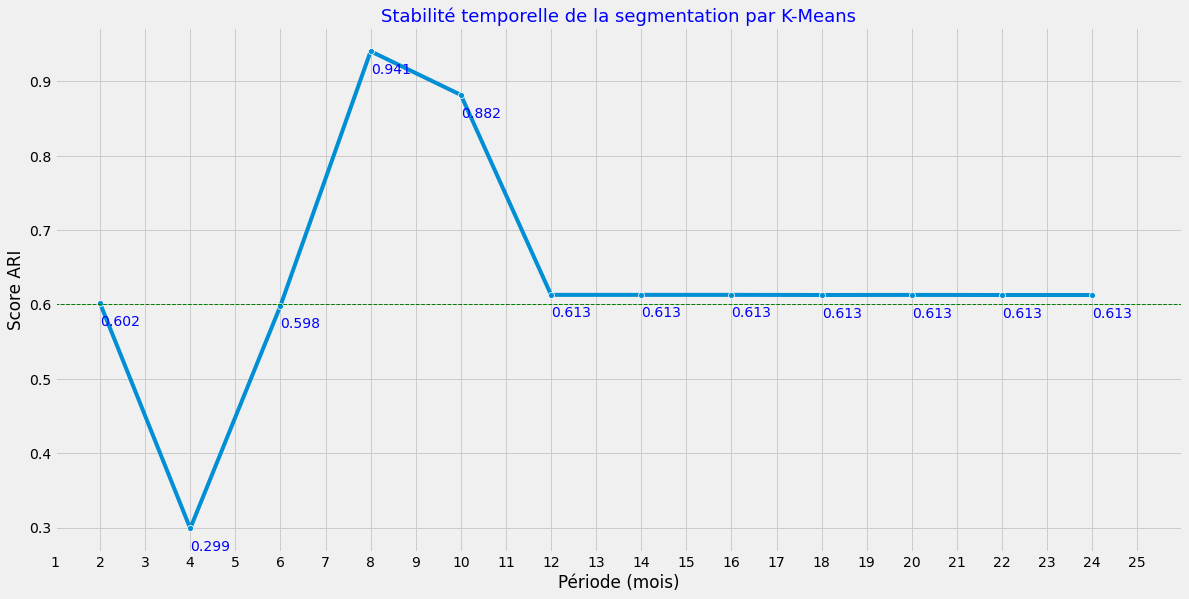

In [173]:
ari_score_2month = pd.DataFrame(ari_score_2month, columns=["periode", "ARI"])
display(ari_score_2month)

# graphique de l'indice de Rand ajousté (ARI)
fig = plt.figure(figsize=(18,9))
sns.lineplot(
    data=ari_score_2month, 
    x="periode", 
    y="ARI",
    marker="o"
)
plt.xlim(1,time_delta+3)
plt.axhline(
    y=0.6, 
    linestyle="--", 
    color="green",
    linewidth=1
)

for x, y in zip(ari_score_2month["periode"], ari_score_2month["ARI"]):
    plt.text(
        x = x,
        y = y-0.03,
        s = "{:.3f}".format(y), 
        color = "blue"
    )

plt.xticks(np.arange(1,time_delta+3,1))
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()